In [2]:
import geopandas as gp
import pandas as pd
import os
import json
import pylab as pl
%pylab inline



Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopand works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


##We will use 2 different datasets.
##an interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". for example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
##so let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

## data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

In [3]:
nrg = gp.GeoDataFrame.from_csv("/Users/QCathy/Downloads/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
print nrg.columns


Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')


In [4]:
print  nrg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16170 entries, 16099 to 13482
Data columns (total 24 columns):
NYC Borough, Block, and Lot (BBL)                                  16014 non-null float64
Co-reported BBL Status                                             912 non-null object
BBLs Co-reported                                                   13790 non-null object
Reported NYC Building Identificaiton Numbers (BINs)                13790 non-null object
Street Number                                                      14423 non-null object
Street Name                                                        14458 non-null object
Borough                                                            16170 non-null object
Zip Code                                                           14432 non-null float64
DOF Benchmarking Submission Status                                 16170 non-null object
Site EUI(kBtu/ft2)                                                 12204 non-null obje

#however this datasets does not have the number of units. We can find that in the Pluto dataset.
reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [5]:
##remove

bsize = gp.GeoDataFrame.from_file("/Users/QCathy/Downloads/Manhattan/MNMapPLUTO.shp")
print bsize.columns


Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

in pandas scatter_matrix will plot each column agains each other. that is a great way to begin inspecting your data (though be careful cause it is computationally comsuming for large datasets) 



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10cb4c110>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12c729c50>]], dtype=object)

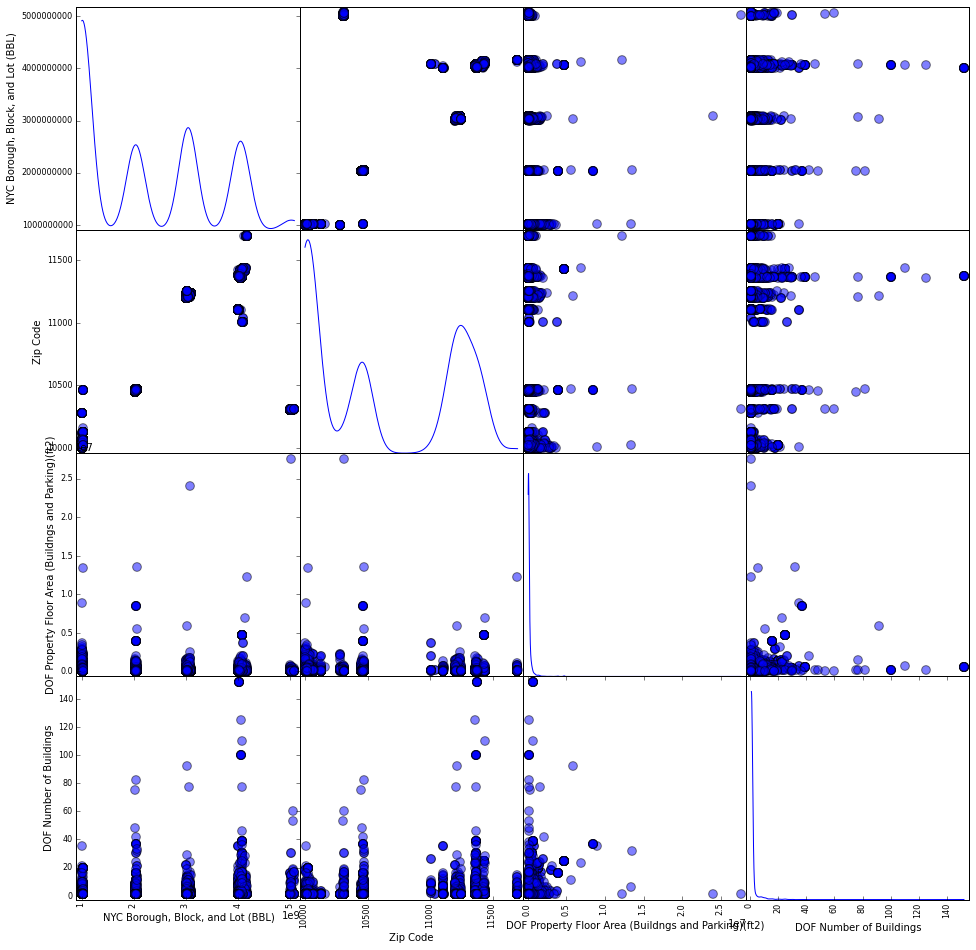

In [6]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16), diagonal='kde')



it will show me correlations between variables, but it will also show me what can and 
cannot be plotted trivially in my dataset! here only a few columns can be plotted: 
those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. 
The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg.       u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: i need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them. 

Below I created a function that returns True if what is passed as argument can be converted to a float, and False otherwise. I do it with the Try/Except structure. it is a very useful python functionality that you should look into.  
this has to be done entry by entry: if you gve t a series you get error "cannot convert the series to <type 'float'>"

However you can pass it a whole array by using it in conjunction with
np.vectorize (look up the syntax!) which will implement a for loop for you under the hood to pass the series entry by entry to your function.


In [7]:

def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False
    

Now for every column i care about i can create an array, call it for eg. indx, of True and False (a Boolean array) that i can use as an index to pick entries that 
I want to use from my arrays of interest. I can replace the entries that failed to be converted to 'NaN'

(because my function return Trues when I can convert and False otherwise i actuallly want the complementary array: ~indx)

In [9]:
#create the indeces array here
#indx = ...
indx1 = np.vectorize(canconvert)(nrg['Site EUI(kBtu/ft2)'])
indx2 = np.vectorize(canconvert)(nrg['Reported NYC Building Identificaiton Numbers (BINs)'])
indx3 = np.vectorize(canconvert)(nrg['Reported Property Floor Area (Building(s)) (ft²)'])

In [11]:
nrg['Site EUI(kBtu/ft2)'][~indx1]=float('NaN')
nrg['Reported NYC Building Identificaiton Numbers (BINs)'][~indx2]=float('NaN')
nrg['Reported Property Floor Area (Building(s)) (ft²)'][~indx3]=float('NaN')

##etc etc... for all columns you care about

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

In [23]:
##check that your conversion worked: e.g.
print nrg['Site EUI(kBtu/ft2)'].astype(float)

Record Number
16099      180.5
500         82.1
5017       137.7
5116       103.2
363         74.0
6876        36.4
10714      114.8
1214       130.0
1544       138.3
1905     56909.0
2301        88.2
15059       15.7
674          NaN
2537        85.7
2841       195.7
2945        79.1
15120      144.1
3053       200.9
4233       104.6
4777        86.7
4912       102.1
5210        21.2
5295        78.3
1575         NaN
15025       55.2
4208        83.2
4799       145.1
1568        59.4
5427        88.7
5476       100.8
          ...   
14559        NaN
14560        NaN
14748        NaN
14753        NaN
13582        NaN
13947        NaN
14777        NaN
14779        NaN
14409        NaN
13262        NaN
13261        NaN
12523        NaN
12529        NaN
12536        NaN
13929        NaN
13944        NaN
13945        NaN
13821        NaN
13829        NaN
13837        NaN
13838        NaN
13847        NaN
14352        NaN
12976        NaN
12978        NaN
12984        NaN
12987        NaN


In [24]:
print nrg['Reported NYC Building Identificaiton Numbers (BINs)'].astype(float)

#[...] check all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want



Record Number
16099    4453435
500      1007817
5017     1063495
5116     1064235
363      1088884
6876     2044217
10714    4075089
1214     1015181
1544     1016899
1905     1022060
2301     1028849
15059    1031751
674      1032045
2537     1032045
2841     1035250
2945     1035788
15120    1036446
3053     1037547
4233     1052315
4777     1060220
4912     1063170
5210     1064460
5295     1065057
1575         NaN
15025        NaN
4208     1082901
4799         NaN
1568     1087118
5427     2002195
5476     2002751
          ...   
14559        NaN
14560        NaN
14748        NaN
14753        NaN
13582        NaN
13947        NaN
14777        NaN
14779        NaN
14409        NaN
13262        NaN
13261        NaN
12523        NaN
12529        NaN
12536        NaN
13929        NaN
13944        NaN
13945        NaN
13821        NaN
13829        NaN
13837        NaN
13838        NaN
13847        NaN
14352        NaN
12976        NaN
12978        NaN
12984        NaN
12987        NaN


In [12]:
print nrg['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)

Record Number
16099     91968
500      235370
5017      64806
5116      62839
363       98000
6876      53275
10714     61846
1214     204417
1544      60110
1905     457946
2301     511001
15059     56442
674       60939
2537      78435
2841      80293
2945     104990
15120    528180
3053     440895
4233      69656
4777      62300
4912      64838
5210      80917
5295      62205
1575     292061
15025     66000
4208     509100
4799      56170
1568      76430
5427      76992
5476      72000
          ...  
14559       NaN
14560       NaN
14748       NaN
14753       NaN
13582       NaN
13947       NaN
14777       NaN
14779       NaN
14409       NaN
13262       NaN
13261       NaN
12523       NaN
12529       NaN
12536       NaN
13929       NaN
13944       NaN
13945       NaN
13821       NaN
13829       NaN
13837       NaN
13838       NaN
13847       NaN
14352       NaN
12976       NaN
12978       NaN
12984       NaN
12987       NaN
12988       NaN
13472       NaN
13482       NaN
Name: Repo

In [14]:
print bsize.BBL.astype(float)
#notice i can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!

0        1002760020
1        1002280022
2        1005900056
3        1005890030
4        1005310056
5        1011860040
6        1004940026
7        1005580017
8        1001807505
9        1005820050
10       1004680049
11       1008090073
12       1002040034
13       1002270019
14       1001367504
15       1006120028
16       1004230028
17       1004100032
18       1008980025
19       1008970053
20       1007870058
21       1003850030
22       1003870119
23       1009110055
24       1004070039
25       1004360002
26       1008850079
27       1007760001
28       1000190013
29       1006220070
            ...    
42756    1017090031
42757    1011710069
42758    1011090100
42759    1015320036
42760    1010517502
42761    1006990009
42762    1007460059
42763    1007760033
42764    1002460005
42765    1019120043
42766    1018520020
42767    1017270067
42768    1007050050
42769    1022150806
42770    1005310016
42771    1017800075
42772    1003010011
42773    1016527501
42774    1004930030


#TO MERGE THE DATASET WE NEED A COMMON COLUMN
here is where you want to merge the datasets. You need a common column: the building id BBL
However the name of this variable (column) in the Energy dataset is     'NYC Borough, Block, and Lot (BBL)'. create a column 'BBL' in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!) 

In [15]:
#nrg['BBL'] = ...
#bblnrgdata = pd.merge(.....)
nrg['BBL'] = nrg['NYC Borough, Block, and Lot (BBL)']
bblnrgdata = pd.merge(nrg, bsize, how='inner', on=['BBL'])

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/index.py:1695: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target.values)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/index.py:1049: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


once you have the dataframe with all the info you want, you want to plot 
Energy vs Number of Units in the Building. 
Remember: Energy TOTAL, not per sq ft...
Here you can choose what you think makes more sense for the number of units: all units, residential units...
make a 'natural' scale scatter plot first it will look really bad cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000.
perhaps zoom into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

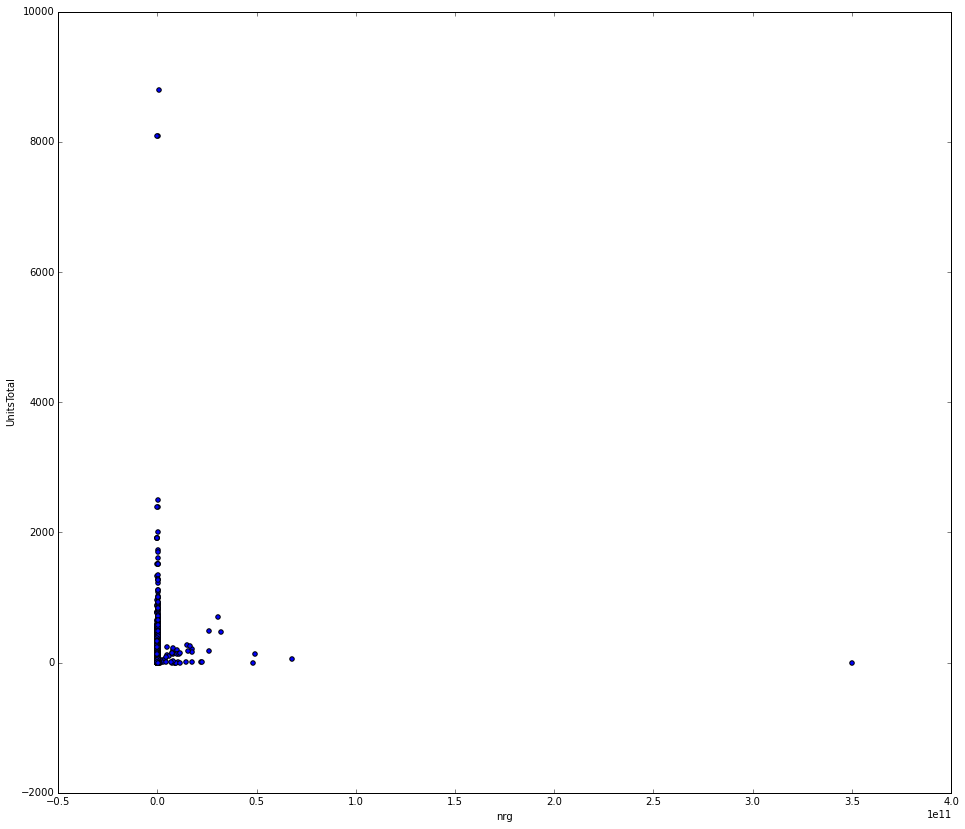

In [17]:
bblnrgdata['nrg'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)*\
                    bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)
fig = figure(figsize=(15,15))
bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', marker='o', figsize=(16, 14))

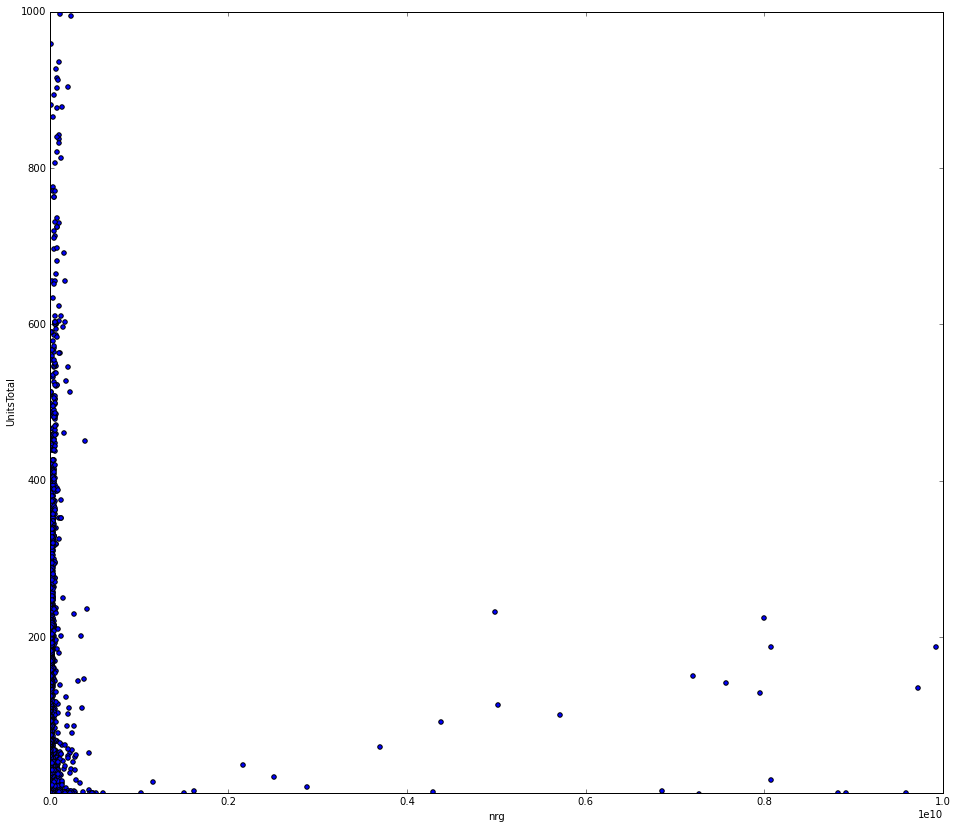

In [18]:
bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', marker='o', figsize=(16, 14), xlim=(1000,1e10), ylim=(1,1000))

when the points in a plot all look scrunched against the axis try a log plot! in pandas you enable that with the keyword 'loglog' :
bblnrgdata.plot(..... loglog=True)

NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data i had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array:
something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

also i removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however  they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.


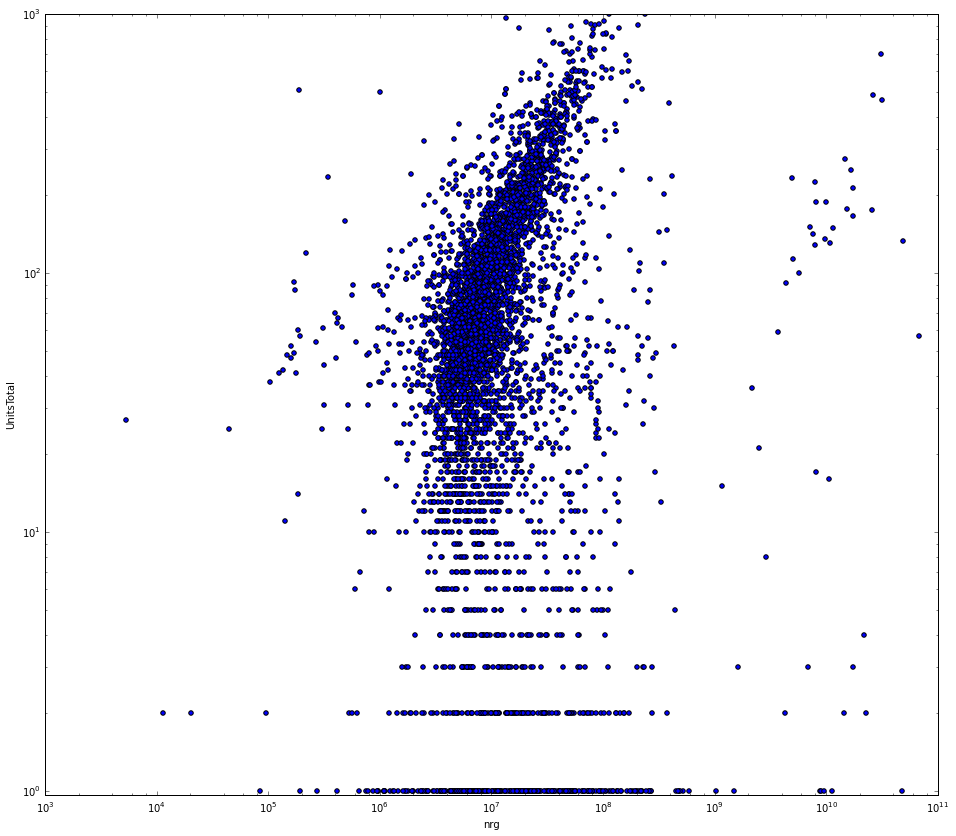

In [20]:
bblnrgdata.clean = bblnrgdata[(bblnrgdata.nrg>1000) & (bblnrgdata.nrg<1e11) & (bblnrgdata.UnitsTotal>0) \
                            & (bblnrgdata.UnitsTotal<1000)]
bblnrgdata.clean.plot(kind = 'scatter',x = 'nrg',y = 'UnitsTotal', marker = 'o', figsize = (16, 14),  xlim = (1000,1e11), ylim=(0,1000)\
                ,loglog = True)

Now fit a line through the data. you can use whatever you want to do it: 
statsmodels, scipy, any other package, or write your own minimization of the residuals
## BUT REMEMBER: we see hints of a lienar relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:

if you used statsmodels it would look something like this:

In [16]:
#X = sm.add_constant(np.log10(x))
#print X
#model = sm.OLS(np.log10(y), X, missing='drop').fit() # ignores entires where x or y is NaN
#fit = model.fit()
#return fit.params[1], fit.params[0], fit # could also return stderr in each via fit.bse

remember to choose wisely which is your DEPENDENT and which is your INDEPENDENT variable. 
both for what you want to do logically (what changes as a functino of what) but also based on which  variable has a 'sensible' distribution that allows you to fit a function to it: 
    you need your independent variable to span a large range, and to be spread somewhat evenly in the range, 
    rather than just clustered in a spot
    


#### Energy vs units

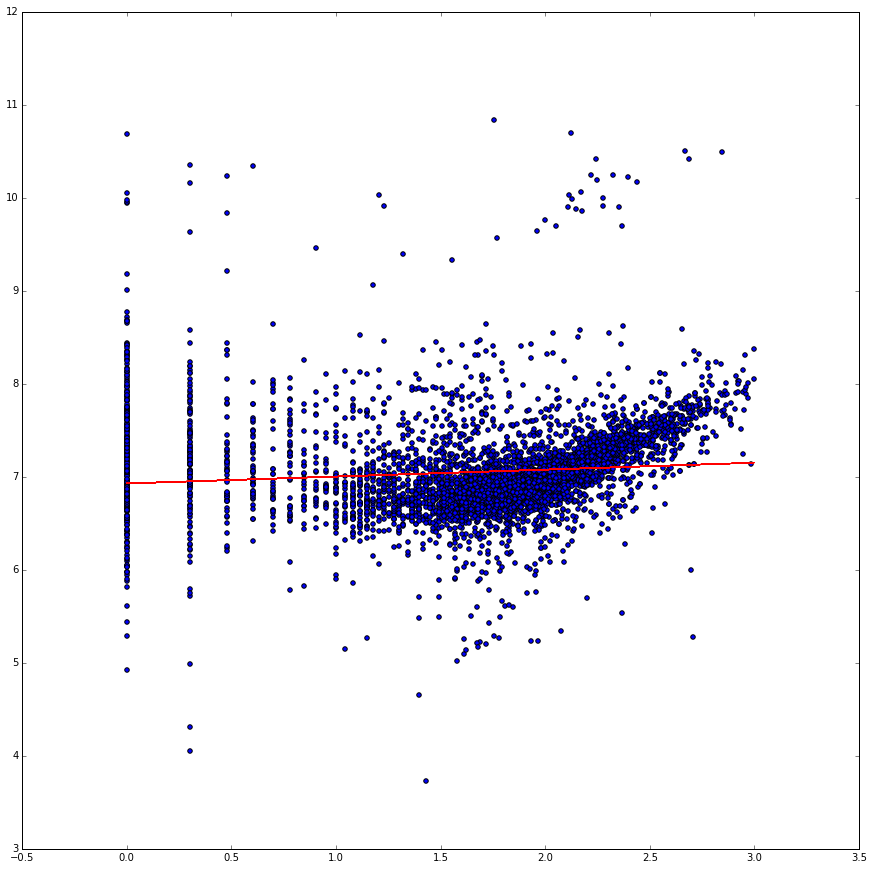

In [25]:
#fit and plots here
import statsmodels.formula.api as smf
dt = pd.DataFrame({'nrg_log':np.log10(bblnrgdata.clean.nrg),
                  'UnitsTotal_log':np.log10(bblnrgdata.clean.UnitsTotal)})
model1 = smf.ols('nrg_log ~ UnitsTotal_log', data=dt).fit()
pl.figure(figsize = (15,15))
pl.scatter(dt.UnitsTotal_log, dt.nrg_log)
plot(dt.UnitsTotal_log, model1.predict(),'r')

#### Units vs energy

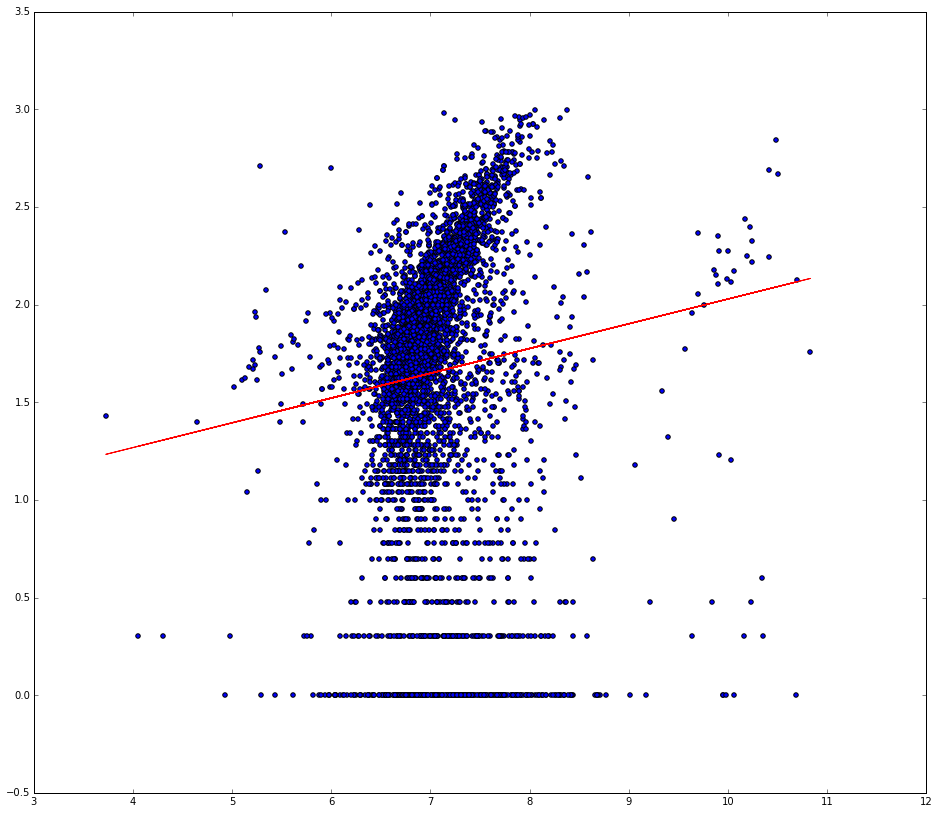

In [27]:
model2 = smf.ols('UnitsTotal_log ~ nrg_log', data=dt).fit()
pl.figure(figsize=(16,14))
pl.scatter(dt.nrg_log,dt.UnitsTotal_log)
plot(dt.nrg_log,model2.predict(),'r')

### try making a fit for energy vs units AND a fit for units vs energy. 
### tell me which is better. 
According to the plots above, the plot for energy vs units is better.

## look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

In [29]:
print model1.summary()

                            OLS Regression Results                            
Dep. Variable:                nrg_log   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     47.39
Date:                Sun, 18 Oct 2015   Prob (F-statistic):           6.54e-12
Time:                        21:17:10   Log-Likelihood:                -3814.5
No. Observations:                4976   AIC:                             7633.
Df Residuals:                    4974   BIC:                             7646.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          6.9282      0.019    358.

In [30]:
print model2.summary()

                            OLS Regression Results                            
Dep. Variable:         UnitsTotal_log   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     47.39
Date:                Sun, 18 Oct 2015   Prob (F-statistic):           6.54e-12
Time:                        21:19:16   Log-Likelihood:                -5141.1
No. Observations:                4976   AIC:                         1.029e+04
Df Residuals:                    4974   BIC:                         1.030e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.7602      0.130      5.835      0.0

## now fit a second degree curve to it: a*x^2+b*x+c. 
that is still called a linear fir by the way, the "linear" definition refers to the PARAMETERS being linear, not to the variable!
you can use np.polyfit for example (an example showned in the other assignment notebook), with order 2 instead of 1,

np.polyfit(x, y, 2)

or statmodels.formula.api passing a formula like 

formula = 'y ~ 1 + x + I(x ^ 2.0)'

## look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

#### The prerequisite to do likelihood ratio test is that the model is nested model. So we can not do likelihood ratio test here.

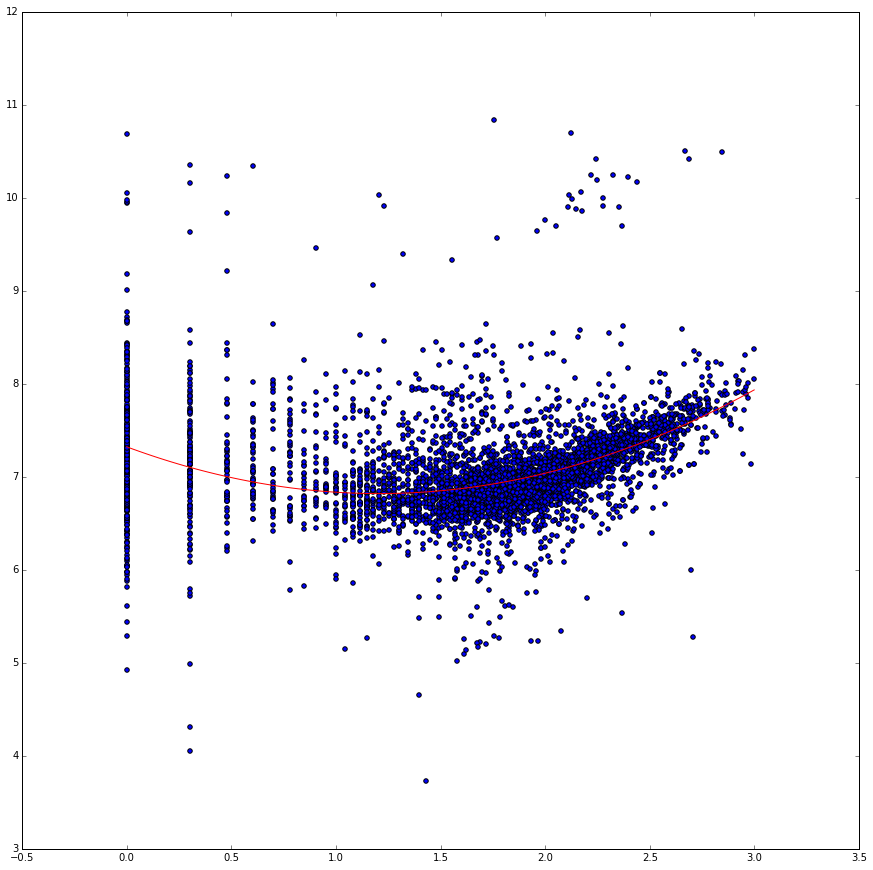

In [32]:
model3 = smf.ols('nrg_log ~ 1+UnitsTotal_log+I(UnitsTotal_log**2.0)', data=dt).fit()
pl.figure(figsize=(15,15))
pl.scatter(dt.UnitsTotal_log, dt.nrg_log)
x= pd.DataFrame({'UnitsTotal_log': np.linspace(dt.UnitsTotal_log.min(), dt.UnitsTotal_log.max(), 100)})
plot(x,model3.predict(x),'r')

In [33]:
print model3.summary()

                            OLS Regression Results                            
Dep. Variable:                nrg_log   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     457.2
Date:                Sun, 18 Oct 2015   Prob (F-statistic):          5.23e-183
Time:                        23:40:48   Log-Likelihood:                -3418.1
No. Observations:                4976   AIC:                             6842.
Df Residuals:                    4973   BIC:                             6862.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept               

EXTRA CREDIT: 
    
use WLS the weighted sq fit instead of OLS. you need to give weights to your points: 
estimates of the errors. the easiest thing is the sqrt of the datapoint value.
if you want to be more sophisticated you can estimate the variance of your data
near each point and use that 

Lastly: do it by hand and create a function that minimizes the residuals: 
       
the residuals are the sum of the differences between data and model: 
in the case of a line fit model (and you can use your errors if you did the extra credit!)

sum(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2

where a and b are the parameters returned by the line fitter. 
for each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope

write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


for i,a in enumerate(A):

    for j,b in enumerate(B):
    
         Lsurface[i][j].....

this gives you a 2D array that represents your likelihood surface! what we do to find a good fit is find the minimum (lowest point) on this surface. 

you can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap"

but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface))
and see if it helps!
also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. do that with the keyword extent: 
pl.imshow(Lsurface, .... , extent = [minimum, and max of your y array, minimum, and max of your x array]...) (notice that the numbers are switched! make sure to verify which axis is the slope, which is the intercept)

In [35]:
##create the array
##[...]
##pl.figure(figsize=(10,10))
##pl.title ("log likelihood surface", fontsize = 22)
##pl.imshow(np.log(Lsurface), extent = ..., aspect=...)
##[...]
##pl.colorbar()

EXTRA CREDIT: get creative with the dataset! can you make an insigntful plot to show any structure in the data?
    
below is my silly attempt at that




/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


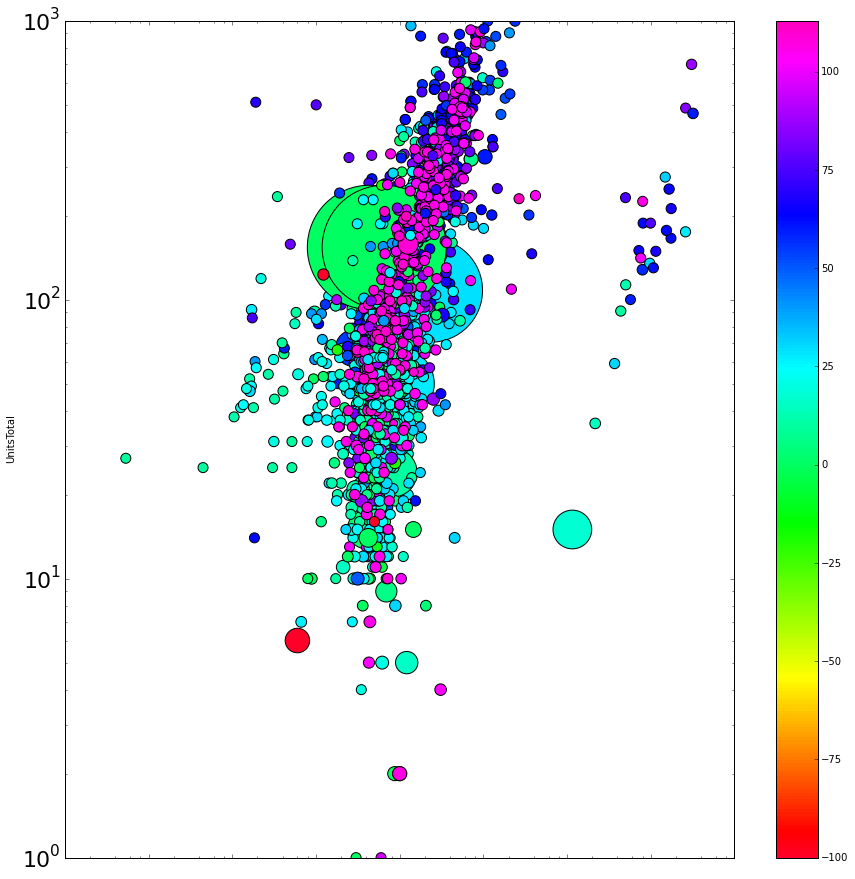

In [39]:
bblnrgdata.clean['YearBuilt'][bblnrgdata.clean['YearBuilt']<1800]=1800

bblnrgdata.clean.plot(kind='scatter',x='nrg',y='UnitsTotal', fontsize=22, colormap='gist_rainbow', alpha = 1, marker='o',  figsize=(15, 15), 
                      loglog=True,  xlim=(1000,1e11), ylim=(1,1000), c=bblnrgdata.clean['YearBuilt']-1900, s=bblnrgdata.clean['UnitsTotal']/bblnrgdata.clean['UnitsRes']*100)